# Example of the modeID class to identify modes in KIC2991448

This is a notebook showing a rough draft of the replacement module for KDE and Asy_peakbag.

We'll start with a few imports.

In [1]:
from pbjam import IO
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 

We'll use the IO module to load the PSD. This is a new module that contains a lot of I/O related tools, saving/loading/downloading etc. In essence it just wraps the various lightkurve steps to getting a PSD. 

Importantly, the IO.psd class normalizes the PSD consistently (Parseval). This is important now that we're working on the PSD and not the SNR spectrum. 

**Note:** If you are using a custom PSD be sure it is Parseval normalized. The easiest way to do this is to start with the custom time series and use the IO.psd class to compute the psd.

Using cached search result.
Loading fits files from cache.


Text(0.5, 0, 'Frequency [$\\mu$Hz]')

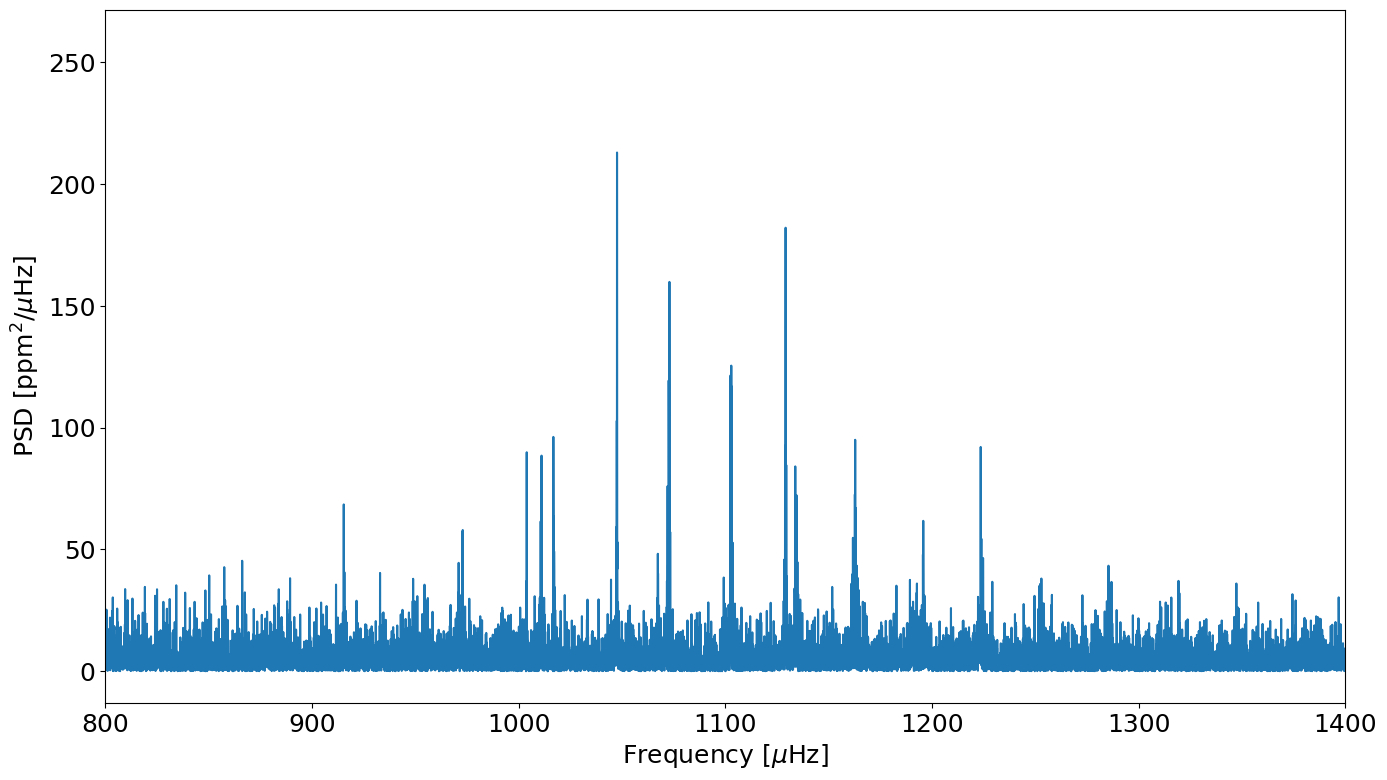

In [2]:
ID = 'KIC2991448'

psd = IO.psd(ID, lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'}, use_cached=True)
 
psd()

f = psd.freq

s = psd.powerdensity

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(f,s)
ax.set_xlim(800, 1400)
ax.set_ylabel('PSD [ppm$^2/\mu$Hz]')
ax.set_xlabel('Frequency [$\mu$Hz]')

## Observational parameters
As with the previous version of PBjam we supply some basic initial parameters to guide the mode ID process. These are $T_{\mathrm{eff}}$, Gaia $G_{\mathrm{bp}}-G_{\mathrm{rp}}$ color index, an estimate of $\nu_{\mathrm{max}}$ and $\Delta \nu$.

In [3]:
addObs = {'teff' : (5486, 80), # K
          'bp_rp': (0.87, 0.05), # mag
          'numax': (1080, 20.0), # muHz
          'dnu'  : (61.5, 0.5)} # muHz

## Priors
With the update to PBjam we now apply a PCA-based dimensionality reduction method to the sample of prior observations for each of the model parameters. This means that the priors are constructed in a lower-dimensional latent space, instead of the full model space. We then compute 1D KDEs of the latent parameter distributions, which are then used in the sampling.

This relies on the sample of prior observations being fairly dense in the parameter space around the target star. Due to the increased model complexity ($\ell=1$ modes for example) PBjam doesn't currently have complete coverage of all parameters in all parts of parameterspace. We therefor added an option to include manually specified priors for some of the parameters, in which case they are no longer included in constructing the latent space priors. An example of this is shown below, for KIC2991448 we don't need to this so we proceed without for now.

## Initializing the sampler
The mode identificaiton in PBjam 2.0 is done by the modeID module. Broadly speaking it takes two main steps:

1. We first identifies the $\ell=2,0$ modes by sampling a simple model of asymptotic p-modes. We include a background model at this stage as well.

2. We then divide the PSD by this model to obtain a residual SNR spectrum which mostly just contains $\ell=1$ modes. We then apply a choice of three different models to this residual to find the $\ell=1$ modes. 

Let's start by initializing the mode ID and running the $\ell=2,0$ model. The mode ID class takes the frequency and spectrum arrays we difined above, as well as the dictionary of observational parameters. 

As in the first version of PBjam the choice of the number of radial p-mode orders, $N_p$, is left to the user. Note that including an excessive amount of orders will probably not improve the result since we rely on the 2nd order asymptotic relation for p-modes, which is only reliable within a few orders of $\nu_{\mathrm{max}}$ anyway. A suitable number for most stars is between 5-10.

Lastly we also specify the frequency range on which the model is constructed. If you're interested in the background parameters this should be left empty since PBjam will then assume you want a model running from $\nu=0$ to the Nyquist frequency. However, if you only care about the modes it's sufficient to just specify a range around the envelope. 

In [4]:
from pbjam.modeID import modeID

N_p = 9
 
M = modeID(f, s, addObs, N_p=N_p, freqLimits = [700, 1500])

Next we can run the $\ell=2,0$ model. For those who have used PBjam 1.0 this should be fairly familiar. 

Note that here we specify the choice of samples to draw from the available prior parameter measurements. Between 50-100 samples is usually sufficient to make a reasonable prior PDF, but if you find that your results appear biased, it may be that PBjam cannot find the requested numbers near your target and so is forced to look further away. If this happens you can decrease the PCAsamples number, which will reduce this bias but with the trade-off that the resulting prior PDF potentially less informative. 

The `PCAdims` sets the dimensionality of the latent space where the prior is constructed, there is no right answer to the choice of this value, but 5-6 is usually sufficient.

In [5]:
M.runl20model();

12175it [02:00, 101.30it/s, +600 | bound: 119 | nc: 1 | ncall: 343680 | eff(%):  3.724 | loglstar:   -inf < -42400.515 <    inf | logz: -42420.421 +/-  0.190 | dlogz:  0.001 >  0.609]


Next we can run the $\ell=1$ model. Here the user must make a choice for which model to apply. The choices of models are essentially:
- `MS`: when there are no g-modes near the p-modes. Typically applicable to main-sequence stars.
- `SG`: when you expect a few g-modes to couple to many p-modes. Typically applicable to sub-giants.
- `RGB`: when you expect lots of g-modes to couple to few p-modes. Typically applicable to low-luminosty red giants.

Exceptions to the above suggestions of course exist, so if in doubt try different models. All the models should run, but results may vary.

In this case KIC2991442 is sub-giant that has just started evolving off the main-sequence, so we only expect a handful of g-modes to be able to couple to the p-modes, so let's pick the `SG` model. 

**Note:** unless you're running the `MS` model, the sampling will probably take a while longer than for the $\ell=2,0$ since it's a more complicated model.

In [ ]:
M.runl1model(model='SG');

1008it [00:00, 2417.27it/s, +500 | bound: 0 | nc: 1 | ncall: 4401 | eff(%): 38.657 | loglstar:   -inf < -4.207 <    inf | logz: -5.314 +/-    nan | dlogz:  0.001 >  0.509]
40307it [06:53, 89.10it/s, bound: 244 | nc: 41 | ncall: 1536103 | eff(%):  2.624 | loglstar:   -inf < -15041.598 <    inf | logz: -15078.895 +/-  0.182 | dlogz:  3.634 >  1.059] 

In [ ]:
M.echelle(stage='posterior');

In [ ]:
fig, ax = M.spectrum(stage='posterior');

## Specifying manual prior probability densities

In the event that your target is in a part of parameterspace that is poorly samples it may sometimes be necessary to provide a prior manually.

In PBjam 2.0 this is done by supplying a distribution class instance from the `pbjam.distributions` module. These function more or less the same as the corresponding `scipy.stats` versions, with the important distinction that they can be incorporated into a function that is jit-compiled with Jax. Note that Jax is continually being developed, so these functions may be redundant in the future. 

An example could be if we are reasonably certain about the period spacing, $\Delta\Pi_1$, for a star, and so don't want PBjam to define a prior on its own. Or if PBjam consistently finds the wrong solution for the p-mode offset $\epsilon_p$.  





In [ ]:
import pbjam.distributions as dist

addPriors = {'DPi1': dist.normal(loc=516.69, scale=10)}

In [ ]:
M_manual = modeID(f, s, addObs, N_p=N_p, addPriors=addPriors, freqLimits = [800, 1400])

In [ ]:
M.runl20model();

In [ ]:
For the g-mode parameters the prior sample is not even remotely complete. To get around this we have the option to supply the modeID class with a list of priors for these parameters. They will then automatically be removed from the list of parameters included in the DR.

These priors are all in the form of class instances of distributions, similar to the scipy.stats classes. However, here we're using a set of custom classes that have been jaxed.